# **Model Creation + Data Split**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from glob import glob
import scipy.io
import torch.nn as nn
import torch
import numpy as np

data_array = np.load('/content/drive/MyDrive/GP-Data/data_array.npy')
label_array = np.load('/content/drive/MyDrive/GP-Data/label_array.npy')
group_array = np.load('/content/drive/MyDrive/GP-Data/group_array.npy')

print(data_array.shape,label_array.shape,group_array.shape)

(7150, 1250, 33) (7150,) (7150,)


### **Mimo siplt**

In [3]:
from sklearn.model_selection import GroupKFold
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
import numpy as np

gkf=GroupKFold()
class StandardScaler3D(BaseEstimator,TransformerMixin):
    #batch, sequence, channels
    def __init__(self):
        self.scaler = StandardScaler()

    def fit(self,X,y=None):
        self.scaler.fit(X.reshape(-1, X.shape[2]))
        return self

    def transform(self,X):
        return self.scaler.transform(X.reshape( -1,X.shape[2])).reshape(X.shape)


def three_splits(data_array , label_array, group_array):

  # Split data_array into train and validate
  train_groups = []
  for train_index, test_index in gkf.split(data_array, label_array, groups=group_array):
      train_features, train_label = data_array[train_index],label_array[train_index]
      X_test, y_test =data_array[test_index],label_array[test_index]
      train_groups = group_array[train_index]

      scaler=StandardScaler3D()
      train_features=scaler.fit_transform(train_features)
      X_test=scaler.transform(X_test)

      print(f"group={np.unique(group_array[train_index])}")
      print(f"group={np.unique(group_array[test_index])}")
      break

  # Split train_features into train and val
  for train_index, val_index in gkf.split(train_features, train_label, groups= train_groups):
      X_train, y_train =train_features[train_index],train_label[train_index]
      X_val, y_val =train_features[val_index],train_label[val_index]

      print(f"group={np.unique(group_array[train_index])}")
      print(f"group={np.unique(group_array[val_index])}")

      break

  return X_train, X_val, X_test, y_train, y_val, y_test




def two_splits(data_array , label_array, group_array):

  # Split data_array into train and validate
  train_groups = []
  for train_index, test_index in gkf.split(data_array, label_array, groups=group_array):
      X_train, y_train = data_array[train_index],label_array[train_index]
      X_test, y_test =data_array[test_index],label_array[test_index]
      train_groups = group_array[train_index]

      scaler=StandardScaler3D()
      X_train=scaler.fit_transform(X_train)
      X_test=scaler.transform(X_test)

      print(f"group={np.unique(group_array[train_index])}")
      print(f"group={np.unique(group_array[test_index])}")
      break

  return X_train, X_test, y_train, y_test


#X_train, X_val, X_test, y_train, y_val, y_test = three_splits(data_array , label_array, group_array)

X_train, X_test, y_train, y_test = two_splits(data_array , label_array, group_array)

# convert the problem from multiclass classification to binary classification
# make haemorrhage and schaemia classes as one

y_train[y_train==0] = 1
y_train[y_train==2] = 0

#y_val[y_val==0] = 1
#y_val[y_val==2] = 0

y_test[y_test==0] = 1
y_test[y_test==2] = 0

group=[ 0  1  2  3  4  5  6  7  8 10 11 12 13 15 16 18 19 20 22 23 25 27 28 29
 30 31 34 36 37 38 39 40 41 42 43 44 45 46 47]
group=[ 9 14 17 21 24 26 32 33 35]


In [5]:
print((y_train == 0).sum())
print((y_test == 0).sum())

print((y_train == 1).sum())
print((y_test == 1).sum())

2361
435
3406
948


# **Mimo split CNN**

In [17]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, concatenate, Dense, MaxPooling1D, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import StratifiedKFold

def block(input):
    conv1 = Conv1D(32, 2, strides=2, activation='relu', padding="same")(input)
    conv2 = Conv1D(32, 4, strides=2, activation='relu', padding="causal")(input)
    conv3 = Conv1D(32, 8, strides=2, activation='relu', padding="causal")(input)
    x = concatenate([conv1, conv2, conv3], axis=2)
    return x

# Define the input layer with a shape of (1250, 33)
input_layer = Input(shape=(1250, 33))

# Create the first block
block1 = block(input_layer)

# Create the second block using the 'block' function with the output of the first block as input
block2 = block(block1)

# Create the third block using the 'block' function with the output of the second block as input
block3 = block(block2)

cnn_out1 = Conv1D(32, 3, activation='relu', padding='same')(block3)
cnn_out2 = Conv1D(32, 3, activation='relu', padding='same')(cnn_out1)
cnn_out3 = MaxPooling1D(pool_size=2)(cnn_out2)
cnn_out4 = Flatten()(cnn_out3)

# Create a Dense layer with 1 unit and sigmoid activation for binary classification
predictions = Dense(1, activation='sigmoid')(cnn_out4)

# Define the model with 'input_layer' as the input and 'predictions' as the output
model = Model(inputs=input_layer, outputs=predictions)

# Specify the Adam optimizer with a learning rate of 0.0001
optimizer = Adam(learning_rate=0.0001)

# Compile the model with binary crossentropy loss and accuracy as the evaluation metric
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Define Stratified K-Fold cross-validator
skf = StratifiedKFold(n_splits=5, shuffle=False)

# Train and evaluate the model using cross-validation
for train_index, val_index in skf.split(X_train, y_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Train the model using training features and labels
    hist = model.fit(X_train_fold, y_train_fold, epochs=100, batch_size=132,
                     validation_data=(X_val_fold, y_val_fold), callbacks=[early_stopping])


Epoch 1/100
35/35 [==============================] - 5s 47ms/step - loss: 0.6923 - accuracy: 0.5658 - val_loss: 0.6863 - val_accuracy: 0.5797
Epoch 2/100
35/35 [==============================] - 1s 24ms/step - loss: 0.6692 - accuracy: 0.5948 - val_loss: 0.6856 - val_accuracy: 0.5745
Epoch 3/100
35/35 [==============================] - 1s 24ms/step - loss: 0.6544 - accuracy: 0.6122 - val_loss: 0.6854 - val_accuracy: 0.5763
Epoch 4/100
35/35 [==============================] - 1s 23ms/step - loss: 0.6394 - accuracy: 0.6280 - val_loss: 0.6857 - val_accuracy: 0.5763
Epoch 5/100
35/35 [==============================] - 1s 23ms/step - loss: 0.6248 - accuracy: 0.6516 - val_loss: 0.6854 - val_accuracy: 0.5745
Epoch 6/100
35/35 [==============================] - 1s 24ms/step - loss: 0.6093 - accuracy: 0.6794 - val_loss: 0.6860 - val_accuracy: 0.5711
Epoch 7/100
35/35 [==============================] - 1s 24ms/step - loss: 0.5915 - accuracy: 0.6922 - val_loss: 0.6871 - val_accuracy: 0.5546
Epoch 

44/44 [==============================] - 1s 4ms/step
Accuracy: 0.6869125090383225
Recall: 0.7489451476793249
Precision: 0.7845303867403315
F1-score: 0.7663248785752834


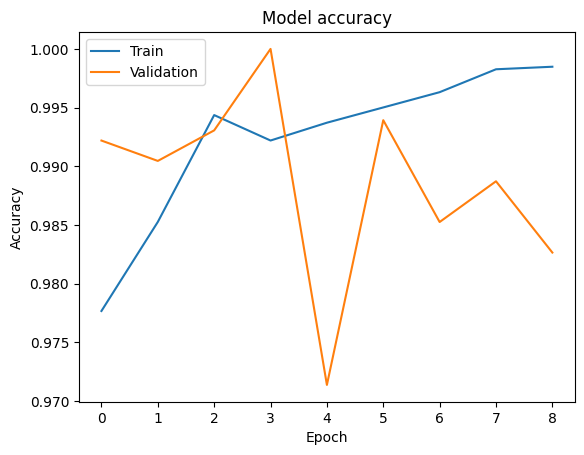

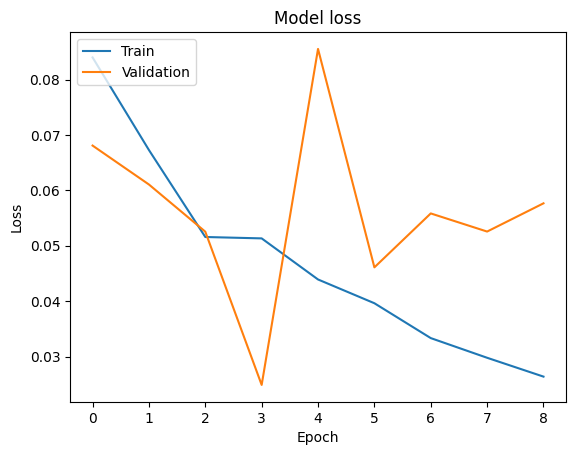

In [18]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

# Predict on test data
y_pred = hist.model.predict(X_test)

#y_pred = hist.model.predict(test_features)
y_pred_binary = (y_pred > 0.5).astype(int)

# Calculate accuracy, recall, precision, and F1-score
accuracy = accuracy_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
f1_score = f1_score(y_test, y_pred_binary)

# Print the results
print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("F1-score:", f1_score)

# plot model accuracy and loss of training and validation
import matplotlib.pyplot as plt
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Average Confusion Matrix:
44/44 [==============================] - 0s 4ms/step


<Figure size 800x600 with 0 Axes>

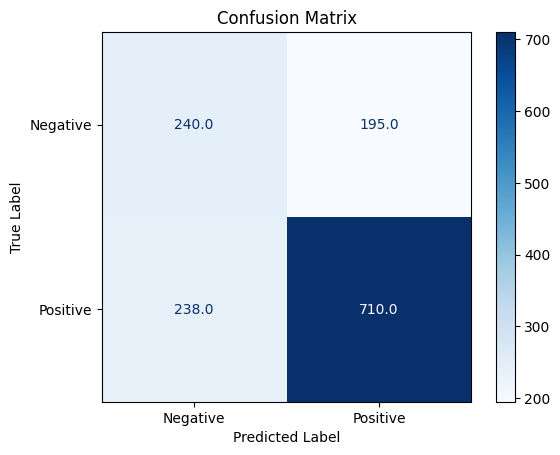

              precision    recall  f1-score   support

           0       0.50      0.55      0.53       435
           1       0.78      0.75      0.77       948

    accuracy                           0.69      1383
   macro avg       0.64      0.65      0.65      1383
weighted avg       0.70      0.69      0.69      1383



In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

print("Average Confusion Matrix:")

y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred)

# Print or use the results as needed
# Calculate confusion matrix
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm_display.plot(cmap='Blues', values_format='.1f')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

from sklearn.metrics import classification_report
# Generate classification report
report = classification_report(y_test.ravel(), y_pred.ravel())

# Print the report
print(report)

In [20]:
import tensorflow as tf

hist.model.save('/content/drive/MyDrive/GP_Models/Mimo_CNN.h5')
#loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/GP-Data/Mimo_CNN.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# **Mimo split LSTM**

In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD, Adam

model = Sequential()
model.add(LSTM(units = 100, return_sequences = True, input_shape = (1250, 33)))
model.add(Dropout(0.2))
model.add(LSTM(units = 100))
model.add(Dropout(0.2))
model.add(Dense(units = 1, activation = 'sigmoid'))
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Define Stratified K-Fold cross-validator
skf = StratifiedKFold(n_splits=5, shuffle=False)

# Train and evaluate the model using cross-validation
for train_index, val_index in skf.split(X_train, y_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Train the model using training features and labels
    hist = model.fit(X_train_fold, y_train_fold, epochs=30, batch_size=128,
                     validation_data=(X_val_fold, y_val_fold), callbacks=[early_stopping])

Epoch 1/30
37/37 [==============================] - 8s 148ms/step - loss: 0.6807 - accuracy: 0.5729 - val_loss: 0.6789 - val_accuracy: 0.5737
Epoch 2/30
37/37 [==============================] - 4s 114ms/step - loss: 0.6617 - accuracy: 0.6031 - val_loss: 0.6830 - val_accuracy: 0.5416
Epoch 3/30
37/37 [==============================] - 4s 115ms/step - loss: 0.5940 - accuracy: 0.6779 - val_loss: 0.7786 - val_accuracy: 0.5104
Epoch 4/30
37/37 [==============================] - 4s 115ms/step - loss: 0.5492 - accuracy: 0.7262 - val_loss: 0.8768 - val_accuracy: 0.5676
Epoch 5/30
37/37 [==============================] - 4s 115ms/step - loss: 0.5597 - accuracy: 0.7357 - val_loss: 0.8936 - val_accuracy: 0.4827
Epoch 6/30
37/37 [==============================] - 4s 116ms/step - loss: 0.5609 - accuracy: 0.7342 - val_loss: 0.7899 - val_accuracy: 0.5303
Epoch 1/30
37/37 [==============================] - 5s 130ms/step - loss: 0.6676 - accuracy: 0.5877 - val_loss: 0.6786 - val_accuracy: 0.5875
Epoch 

44/44 [==============================] - 2s 40ms/step
Accuracy: 0.5777295733911786
Recall: 0.6244725738396625
Precision: 0.7219512195121951
F1-score: 0.669683257918552


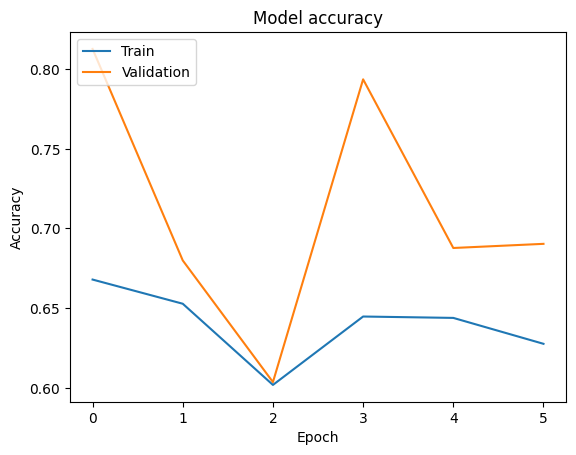

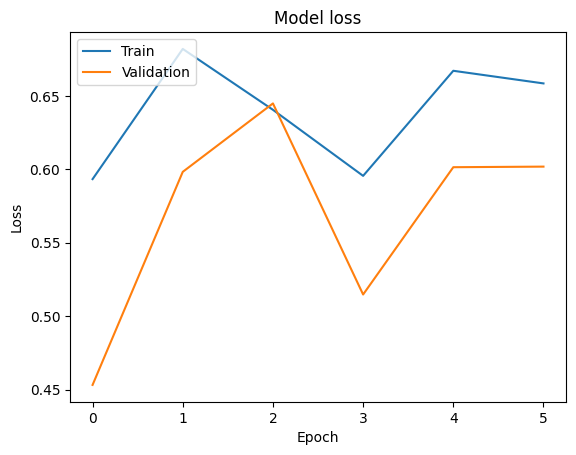

In [40]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

# Predict on test data
y_pred = hist.model.predict(X_test)

y_pred_binary = (y_pred > 0.5).astype(int)

# Calculate accuracy, recall, precision, and F1-score
accuracy = accuracy_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
f1_score = f1_score(y_test, y_pred_binary)

# Print the results
print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("F1-score:", f1_score)

# plot model accuracy and loss of training and validation
import matplotlib.pyplot as plt
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Average Confusion Matrix:
44/44 [==============================] - 2s 40ms/step


<Figure size 800x600 with 0 Axes>

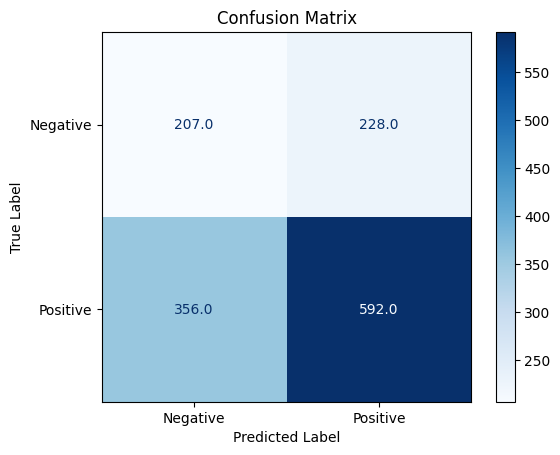

              precision    recall  f1-score   support

           0       0.37      0.48      0.41       435
           1       0.72      0.62      0.67       948

    accuracy                           0.58      1383
   macro avg       0.54      0.55      0.54      1383
weighted avg       0.61      0.58      0.59      1383



In [41]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

print("Average Confusion Matrix:")

y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred)

# Print or use the results as needed
# Calculate confusion matrix
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm_display.plot(cmap='Blues', values_format='.1f')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

from sklearn.metrics import classification_report
# Generate classification report
report = classification_report(y_test.ravel(), y_pred.ravel())

# Print the report
print(report)

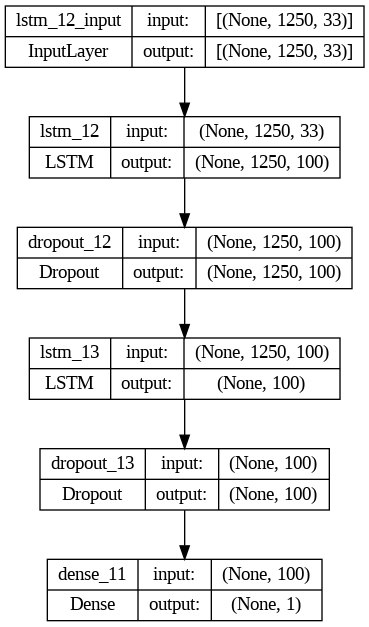

In [43]:
from tensorflow.keras.utils import plot_model

plot_model(model=hist.model, show_shapes=True)

In [42]:
import tensorflow as tf

hist.model.save('/content/drive/MyDrive/GP_Models/Mimo_LSTM.h5')
#loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/GP-Data/Mimo_CNN.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# **Mimo split CNN+LSTM**

In [56]:
from tensorflow.keras.layers import Input, Conv1D, concatenate, Dense, MaxPooling1D, Flatten, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping

# Define the input layer with a shape of (1250, 33)
input_layer = Input(shape=(1250, 33))

# Convolutional Block
conv1 = Conv1D(32, 2, strides=2, activation='relu', padding="same")(input_layer)
conv2 = Conv1D(32, 4, strides=2, activation='relu', padding="causal")(input_layer)
conv3 = Conv1D(32, 8, strides=2, activation='relu', padding="causal")(input_layer)
cnn_output = concatenate([conv1, conv2, conv3], axis=2)

# LSTM Layer
lstm_layer = LSTM(64)(cnn_output)

# Fully Connected Layers
dense1 = Dense(32, activation='relu')(lstm_layer)

# Output Layer
predictions = Dense(1, activation='sigmoid')(dense1)

# Create the model
model = Model(inputs=input_layer, outputs=predictions)

# Compile the model
optimizer = Adam(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


# Train and evaluate the model using cross-validation
for train_index, val_index in skf.split(X_train, y_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Train the model using training features and labels
    hist = model.fit(X_train_fold, y_train_fold, epochs=70, batch_size=64,
                     validation_data=(X_val_fold, y_val_fold), callbacks=[early_stopping])


Epoch 1/70
73/73 [==============================] - 6s 43ms/step - loss: 0.6563 - accuracy: 0.6209 - val_loss: 0.6970 - val_accuracy: 0.5719
Epoch 2/70
73/73 [==============================] - 2s 28ms/step - loss: 0.4537 - accuracy: 0.7789 - val_loss: 0.6974 - val_accuracy: 0.6976
Epoch 3/70
73/73 [==============================] - 2s 29ms/step - loss: 0.1993 - accuracy: 0.9237 - val_loss: 0.4829 - val_accuracy: 0.8258
Epoch 4/70
73/73 [==============================] - 2s 28ms/step - loss: 0.1280 - accuracy: 0.9564 - val_loss: 1.1011 - val_accuracy: 0.6811
Epoch 5/70
73/73 [==============================] - 2s 29ms/step - loss: 0.1031 - accuracy: 0.9668 - val_loss: 0.7604 - val_accuracy: 0.7444
Epoch 6/70
73/73 [==============================] - 2s 28ms/step - loss: 0.0807 - accuracy: 0.9744 - val_loss: 0.9784 - val_accuracy: 0.7253
Epoch 7/70
73/73 [==============================] - 2s 28ms/step - loss: 0.0995 - accuracy: 0.9670 - val_loss: 0.6341 - val_accuracy: 0.8206
Epoch 8/70
73

44/44 [==============================] - 1s 10ms/step
Accuracy: 0.6558206796818511
Recall: 0.6613924050632911
Precision: 0.8017902813299232
F1-score: 0.7248554913294798


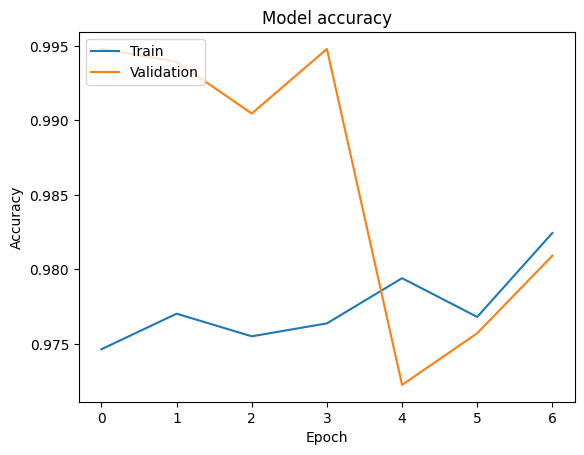

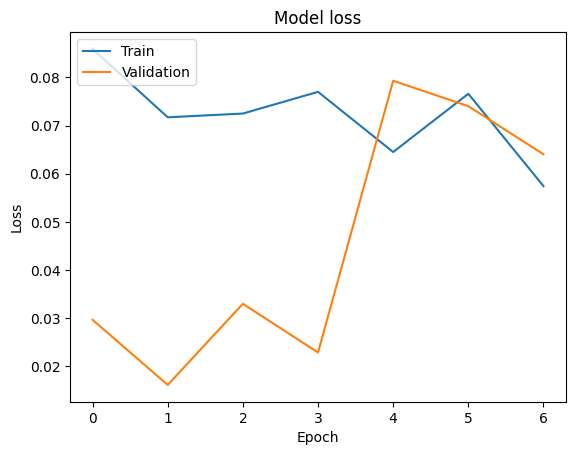

In [57]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

# Predict on test data
y_pred = hist.model.predict(X_test)

y_pred_binary = (y_pred > 0.5).astype(int)

# Calculate accuracy, recall, precision, and F1-score
accuracy = accuracy_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
f1_score = f1_score(y_test, y_pred_binary)

# Print the results
print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("F1-score:", f1_score)

# plot model accuracy and loss of training and validation
import matplotlib.pyplot as plt
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Average Confusion Matrix:
44/44 [==============================] - 0s 10ms/step


<Figure size 800x600 with 0 Axes>

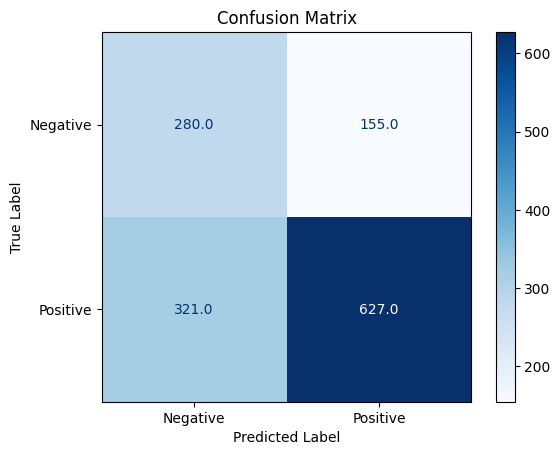

              precision    recall  f1-score   support

           0       0.47      0.64      0.54       435
           1       0.80      0.66      0.72       948

    accuracy                           0.66      1383
   macro avg       0.63      0.65      0.63      1383
weighted avg       0.70      0.66      0.67      1383



In [58]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

print("Average Confusion Matrix:")

y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred)

# Print or use the results as needed
# Calculate confusion matrix
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm_display.plot(cmap='Blues', values_format='.1f')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

from sklearn.metrics import classification_report
# Generate classification report
report = classification_report(y_test.ravel(), y_pred.ravel())

# Print the report
print(report)

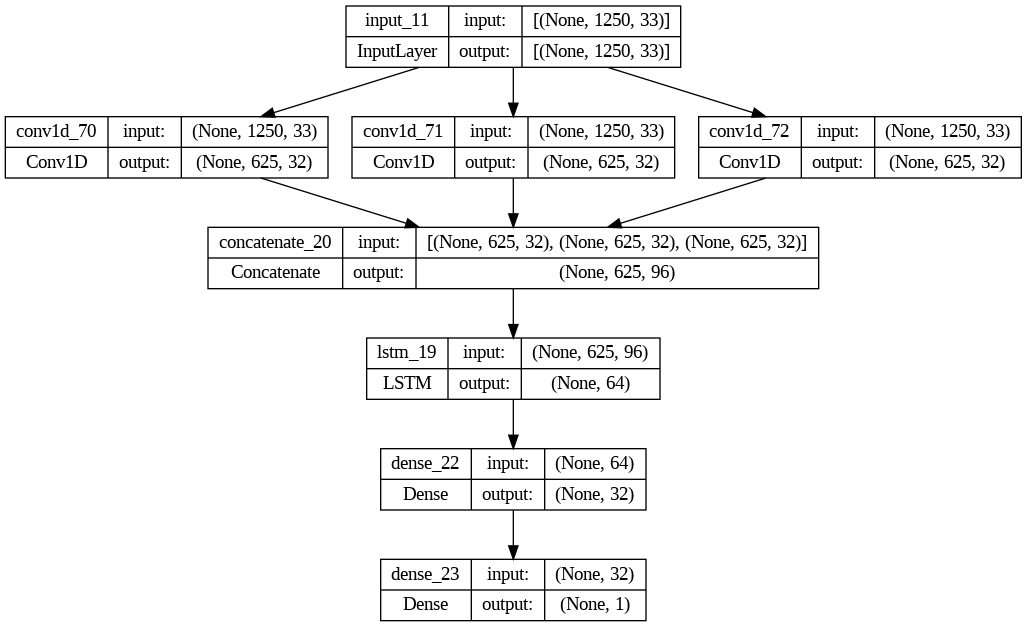

In [59]:
from tensorflow.keras.utils import plot_model

plot_model(model=hist.model, show_shapes=True)

In [60]:
import tensorflow as tf

hist.model.save('/content/drive/MyDrive/GP_Models/Mimo_CNN_LSTM.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# **Mimo Split CNN+GRU**

In [101]:
import tensorflow as tf
from tensorflow.keras.layers import Input,Dense,concatenate,Flatten,GRU,Conv1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

#resource:https://github.com/dll-ncai/eeg_pre-diagnostic_screening/blob/master/code/chrononet/chrono.py

def block(input):

  """
    Create a block consisting of three parallel convolutional layers followed by concatenation.

    Parameters:
    - input: Input tensor.

    Returns:
    - Concatenated tensor resulting from the parallel convolutional layers.
    """

  conv1 = Conv1D(32, 2, strides=2,activation='relu',padding="same")(input)
  conv2 = Conv1D(32, 4, strides=2,activation='relu',padding="causal")(input)
  conv3 = Conv1D(32, 8, strides=2,activation='relu',padding="causal")(input)
  x = concatenate([conv1,conv2,conv3],axis=2)
  return x

# Define the input layer with a shape of (1250, 33)
input = Input(shape=(1250, 33))

# Create the first block
block1 = block(input)

# Create the second block using the 'block' function with the output of the first block as input
block2 = block(block1)

# Create the third block using the 'block' function with the output of the second block as input
block3 = block(block2)

gru_out1 = GRU(32,activation='tanh',return_sequences=True)(block3)
gru_out2 = GRU(32,activation='tanh',return_sequences=True)(gru_out1)
gru_out = concatenate([gru_out1,gru_out2],axis=2)
gru_out3 = GRU(32,activation='tanh',return_sequences=True)(gru_out)
gru_out = concatenate([gru_out1,gru_out2,gru_out3])
gru_out4 = GRU(32,activation='tanh')(gru_out)

# Create a Dense layer with 1 unit and sigmoid activation for binary classification
predictions = Dense(1, activation='sigmoid')(gru_out4)

# Define the model with 'input' as the input and 'predictions' as the output
model = Model(inputs=input, outputs=predictions)

# Specify the Adam optimizer with a learning rate of 0.0001
optimizer = Adam(learning_rate=0.001)

# Compile the model with binary crossentropy loss and accuracy as the evaluation metric
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train and evaluate the model using cross-validation
for train_index, val_index in skf.split(X_train, y_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Train the model using training features and labels
    hist = model.fit(X_train_fold, y_train_fold, epochs=50, batch_size=128,
                     validation_data=(X_val_fold, y_val_fold), callbacks=[early_stopping])



Epoch 1/50
37/37 [==============================] - 13s 91ms/step - loss: 0.6788 - accuracy: 0.5818 - val_loss: 0.6742 - val_accuracy: 0.5910
Epoch 2/50
37/37 [==============================] - 2s 42ms/step - loss: 0.5995 - accuracy: 0.6631 - val_loss: 0.6394 - val_accuracy: 0.6161
Epoch 3/50
37/37 [==============================] - 2s 42ms/step - loss: 0.4327 - accuracy: 0.7889 - val_loss: 1.0176 - val_accuracy: 0.5979
Epoch 4/50
37/37 [==============================] - 2s 41ms/step - loss: 0.3238 - accuracy: 0.8565 - val_loss: 1.0210 - val_accuracy: 0.5962
Epoch 5/50
37/37 [==============================] - 2s 41ms/step - loss: 0.3110 - accuracy: 0.8567 - val_loss: 1.0911 - val_accuracy: 0.5971
Epoch 6/50
37/37 [==============================] - 1s 40ms/step - loss: 0.3306 - accuracy: 0.8552 - val_loss: 1.1693 - val_accuracy: 0.5936
Epoch 7/50
37/37 [==============================] - 2s 41ms/step - loss: 0.1345 - accuracy: 0.9454 - val_loss: 0.7216 - val_accuracy: 0.7244
Epoch 1/50
3

44/44 [==============================] - 2s 11ms/step
Accuracy: 0.6536514822848879
Recall: 0.7774261603375527
Precision: 0.7333333333333333
F1-score: 0.7547363031233999


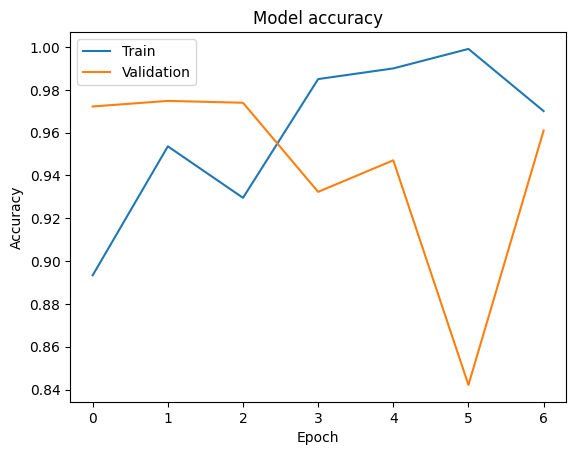

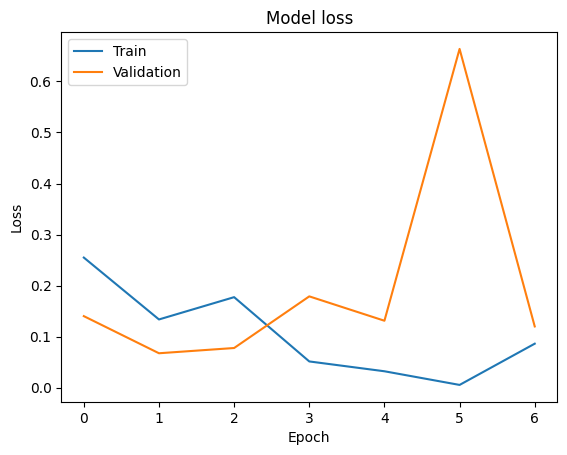

In [102]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

# Predict on test data
y_pred = hist.model.predict(X_test)

y_pred_binary = (y_pred > 0.5).astype(int)

# Calculate accuracy, recall, precision, and F1-score
accuracy = accuracy_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
f1_score = f1_score(y_test, y_pred_binary)

# Print the results
print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("F1-score:", f1_score)

# plot model accuracy and loss of training and validation
import matplotlib.pyplot as plt
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Average Confusion Matrix:
44/44 [==============================] - 1s 11ms/step


<Figure size 800x600 with 0 Axes>

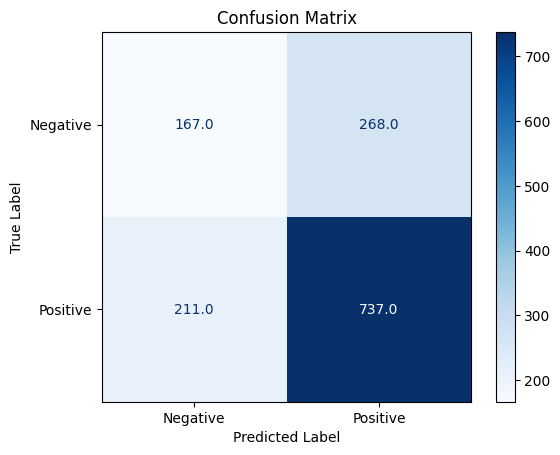

              precision    recall  f1-score   support

           0       0.44      0.38      0.41       435
           1       0.73      0.78      0.75       948

    accuracy                           0.65      1383
   macro avg       0.59      0.58      0.58      1383
weighted avg       0.64      0.65      0.65      1383



In [103]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

print("Average Confusion Matrix:")

y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred)

# Print or use the results as needed
# Calculate confusion matrix
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm_display.plot(cmap='Blues', values_format='.1f')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

from sklearn.metrics import classification_report
# Generate classification report
report = classification_report(y_test.ravel(), y_pred.ravel())

# Print the report
print(report)

In [ ]:
import tensorflow as tf

hist.model.save('/content/drive/MyDrive/GP_Models/Mimo_CNN_GRU.h5')

# **Mimo Split RNN**

In [105]:
from tensorflow.keras.layers import Dense, SimpleRNN

In [108]:
from tensorflow.keras.layers import Input
import tensorflow as tf

input_shape = (1250, 33)  # Define input shape as a tuple

def create_model(input_shape):
    model = Sequential()
    model.add(SimpleRNN(128, input_shape=input_shape, return_sequences=True))  # RNN layer with 128 units and return sequences
    model.add(SimpleRNN(128))  # Additional RNN layer with 128 units
    model.add(Dense(64, activation='relu'))  # Dense layer with 64 units and ReLU activation
    model.add(Dense(1, activation='sigmoid'))  # Output layer with sigmoid activation

    return model

# Pass input shape tuple to the create_model function
model = create_model(input_shape)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train and evaluate the model using cross-validation
for train_index, val_index in skf.split(X_train, y_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Train the model using training features and labels
    hist = model.fit(X_train_fold, y_train_fold, epochs=70, batch_size=132,
                     validation_data=(X_val_fold, y_val_fold), callbacks=[early_stopping])

Epoch 1/70
35/35 [==============================] - 58s 2s/step - loss: 0.7234 - accuracy: 0.4932 - val_loss: 0.7004 - val_accuracy: 0.5251
Epoch 2/70
35/35 [==============================] - 54s 2s/step - loss: 0.6694 - accuracy: 0.5896 - val_loss: 0.6890 - val_accuracy: 0.5468
Epoch 3/70
35/35 [==============================] - 54s 2s/step - loss: 0.6337 - accuracy: 0.6512 - val_loss: 0.6847 - val_accuracy: 0.5485
Epoch 4/70
35/35 [==============================] - 54s 2s/step - loss: 0.6011 - accuracy: 0.6928 - val_loss: 0.6785 - val_accuracy: 0.5737
Epoch 5/70
35/35 [==============================] - 53s 2s/step - loss: 0.5666 - accuracy: 0.7227 - val_loss: 0.6775 - val_accuracy: 0.5823
Epoch 6/70
35/35 [==============================] - 53s 2s/step - loss: 0.5335 - accuracy: 0.7535 - val_loss: 0.6727 - val_accuracy: 0.5927
Epoch 7/70
35/35 [==============================] - 54s 2s/step - loss: 0.5022 - accuracy: 0.7685 - val_loss: 0.6789 - val_accuracy: 0.5927
Epoch 8/70
35/35 [==

44/44 [==============================] - 7s 161ms/step
Accuracy: 0.5784526391901663
Recall: 0.7236286919831224
Precision: 0.6812313803376365
F1-score: 0.7017902813299233


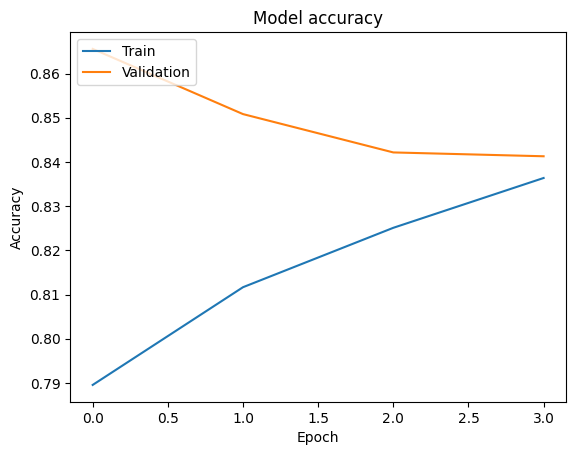

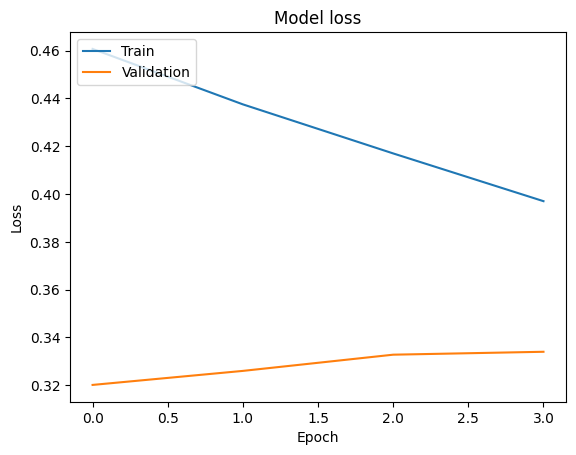

In [109]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

# Predict on test data
y_pred = hist.model.predict(X_test)

y_pred_binary = (y_pred > 0.5).astype(int)

# Calculate accuracy, recall, precision, and F1-score
accuracy = accuracy_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
f1_score = f1_score(y_test, y_pred_binary)

# Print the results
print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("F1-score:", f1_score)

# plot model accuracy and loss of training and validation
import matplotlib.pyplot as plt
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Average Confusion Matrix:
44/44 [==============================] - 7s 161ms/step


<Figure size 800x600 with 0 Axes>

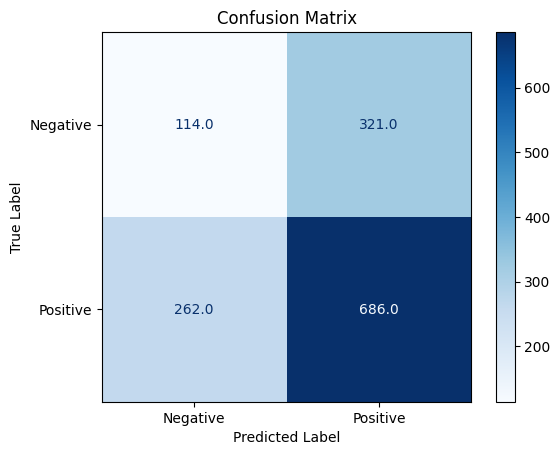

              precision    recall  f1-score   support

           0       0.30      0.26      0.28       435
           1       0.68      0.72      0.70       948

    accuracy                           0.58      1383
   macro avg       0.49      0.49      0.49      1383
weighted avg       0.56      0.58      0.57      1383



In [110]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

print("Average Confusion Matrix:")

y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred)

# Print or use the results as needed
# Calculate confusion matrix
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm_display.plot(cmap='Blues', values_format='.1f')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

from sklearn.metrics import classification_report
# Generate classification report
report = classification_report(y_test.ravel(), y_pred.ravel())

# Print the report
print(report)

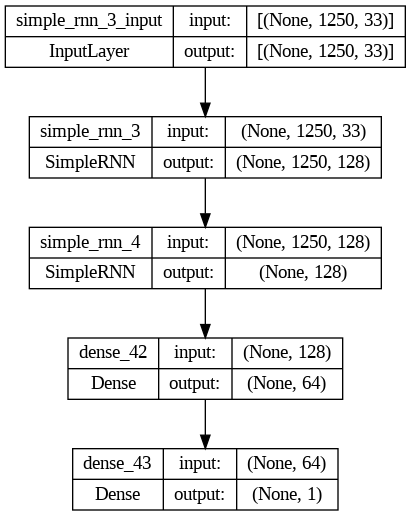

In [113]:
from tensorflow.keras.utils import plot_model

plot_model(model=hist.model, show_shapes=True)

In [111]:
import tensorflow as tf

hist.model.save('/content/drive/MyDrive/GP_Models/Mimo_RNN.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
